<i>Recommendation Systems</i><br>
--
Author by : 
* Nub-T
* D. Johanes

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
import os
import zipfile
CUR_DIR = os.path.abspath(os.path.curdir)
movie_zip = zipfile.ZipFile(CUR_DIR + '/ml-latest-small.zip')
movie_zip.extractall()

In [3]:
import pandas as pd
import numpy as np
from scipy import  sparse, linalg

In [4]:
links = pd.read_csv(CUR_DIR + '/ml-latest-small/links.csv')
movies = pd.read_csv(CUR_DIR + '/ml-latest-small/movies.csv')
ratings = pd.read_csv(CUR_DIR + '/ml-latest-small/ratings.csv')
tags = pd.read_csv(CUR_DIR + '/ml-latest-small/tags.csv')

In [6]:
# Content base Filtering

In [7]:
movies_genres = pd.concat([movies.loc[:,['movieId','title']],movies.genres.str.split('|', expand=False)], axis=1)
movies_genres = movies_genres.explode('genres')
movies_genres = pd.get_dummies(movies_genres,columns=['genres'])
movies_genres = movies_genres.groupby(['movieId'], as_index=False).sum()

In [8]:
assert movies_genres.iloc[:,1:].max().max() == 1
movies_genres.head()

,movieId,genres_(no genres listed),genres_Action,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_IMAX,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western
0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
ratings = pd.read_csv(CUR_DIR + '/ml-latest-small/ratings.csv')

In [12]:
C = 3
total_mean = ratings.rating.mean()
ratings['normalized_rating'] = ratings.rating - total_mean

In [14]:
b_item = ratings.groupby('movieId').normalized_rating.sum() / (ratings.groupby('movieId').userId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_item, columns=['b_item']), left_on='movieId', right_index=True, how='inner')
ratings['norm_item_rating'] = ratings.normalized_rating - ratings.b_item

In [15]:
b_item

movieId
1         0.413602
2        -0.067887
3        -0.228745
4        -0.801090
5        -0.405313
            ...   
193581    0.124611
193583   -0.000389
193585   -0.000389
193587   -0.000389
193609    0.124611
Length: 9724, dtype: float64

In [17]:
b_user = ratings.groupby('userId').norm_item_rating.sum() / (ratings.groupby('userId').movieId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_user, columns=['b_user']), left_on='userId', right_index=True, how='inner')

In [18]:
b_user

userId
1      0.791627
2      0.055496
3     -0.985596
4     -0.169825
5     -0.060708
         ...   
606    0.089329
607    0.266008
608   -0.199666
609   -0.230366
610    0.193503
Length: 610, dtype: float64

In [22]:
ratings['normr_user_item_rating'] = total_mean + ratings.b_item + ratings.b_user
urm = ratings.pivot(index='userId', columns='movieId', values='normr_user_item_rating').fillna(0.).values

In [24]:
shrink_term = 3
movies_genres_mat = sparse.csr_matrix(movies_genres.iloc[:,1:].values)

movie_norms = np.sqrt(movies_genres_mat.sum(axis=1)).reshape(-1,1)
xy, yx = np.meshgrid(movie_norms, movie_norms)
xy, yx = np.array(xy), np.array(yx)

In [27]:
cbf_similarity_mat = movies_genres_mat.dot(movies_genres_mat.transpose())
cbf_similarity_mat = np.array(cbf_similarity_mat / (xy * yx + shrink_term))
np.fill_diagonal(cbf_similarity_mat, 0.)

In [28]:
cbf_similarity_mat

array([[0.        , 0.43649167, 0.16227766, ..., 0.        , 0.16227766,
        0.19098301],
       [0.43649167, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16227766, 0.        , 0.        , ..., 0.        , 0.        ,
        0.22654092],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16227766, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19098301, 0.        , 0.22654092, ..., 0.        , 0.        ,
        0.        ]])

In [29]:
movies['idx'] = movies.index

In [30]:
def get_similar_movies(k, movie_name):
  movie_idx = movies.set_index('title').loc[movie_name,'idx']
  movie_idxs = np.argsort(cbf_similarity_mat[movie_idx,:])[-k:]
  return movies.loc[np.flip(movie_idxs),['title','genres']]

In [32]:
def cbf_get_rating_given_user(u_ix, item_ix, k):
  movie_idxs = np.argsort(cbf_similarity_mat[item_ix,:])[-k:].squeeze()
  subusers_items = urm[u_ix,movie_idxs].squeeze()
  masked_subusers_items = np.ma.array(subusers_items, mask=subusers_items == 0.) 
  weights = cbf_similarity_mat[item_ix, movie_idxs].squeeze()

  w_avg = np.ma.average(a=masked_subusers_items, weights=weights)
  return np.where(w_avg == np.ma.masked, 0., w_avg), masked_subusers_items, weights

In [35]:
cbf_get_rating_given_user(0,0,100)

(array(4.16856985),
 masked_array(data=[4.270988316863774, --, --, --, 4.723657525010937, --,
                    --, 4.17545658424152, --, 4.243639930145966, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, 3.54171043708161, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --],
              mask=[False,  True,  True,  True, False,  True,  True, False,
                     True, False,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     T

In [36]:
get_similar_movies(10, 'Toy Story 2 (1999)')

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6948,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy
1706,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2809,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3000,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
8927,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy
3568,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
8219,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
6194,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
6486,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


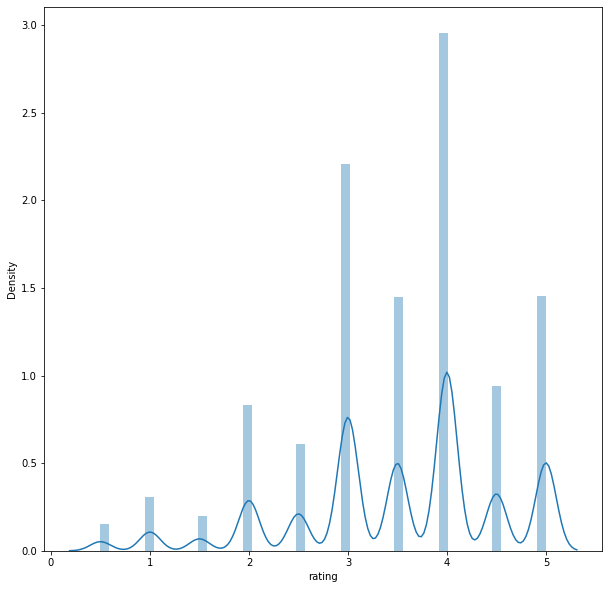

In [37]:
# Collaborative Filtering

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,10))
sns.distplot(ratings.rating, bins=50)
fig.show()

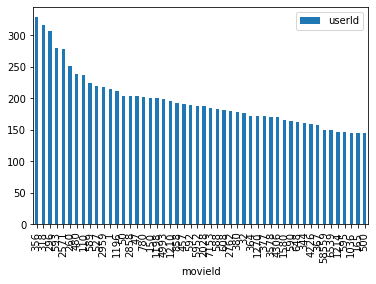

In [38]:
ratings.groupby('movieId').agg({'userId':'count'}).sort_values('userId',ascending=False).loc[:500,:].plot.bar()

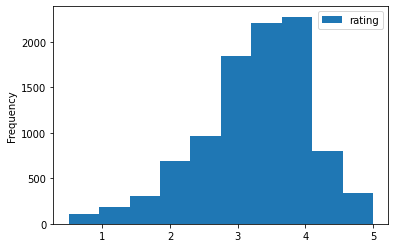

In [39]:
ratings.groupby('movieId').agg({'rating':np.mean}).sort_values('rating',ascending=False).plot.hist()

In [40]:
ratings = pd.read_csv(CUR_DIR + '/ml-latest-small/ratings.csv')

C = 3
total_mean = ratings.rating.mean()
ratings['normalized_rating'] = ratings.rating - total_mean

b_item = ratings.groupby('movieId').normalized_rating.sum() / (ratings.groupby('movieId').userId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_item, columns=['b_item']), left_on='movieId', right_index=True, how='inner')
ratings['norm_item_rating'] = ratings.normalized_rating - ratings.b_item

b_user = ratings.groupby('userId').norm_item_rating.sum() / (ratings.groupby('userId').movieId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_user, columns=['b_user']), left_on='userId', right_index=True, how='inner')

ratings['normr_user_item_rating'] = total_mean + ratings.b_item + ratings.b_user

In [41]:
b_user

userId
1      0.791627
2      0.055496
3     -0.985596
4     -0.169825
5     -0.060708
         ...   
606    0.089329
607    0.266008
608   -0.199666
609   -0.230366
610    0.193503
Length: 610, dtype: float64

In [44]:
urm = ratings.pivot(index='userId', columns='movieId', values='normr_user_item_rating').fillna(0.).values

user_bias = urm.mean(axis=1, keepdims=True)
urm_diff = ((urm - user_bias) / np.std(urm, axis=1, keepdims=True)) / np.sqrt(urm.shape[1]) # With this trick I can do dot product for pearson corr
cf_user_similarity_mat = urm_diff.dot(urm_diff.T)
np.fill_diagonal(cf_user_similarity_mat, 0.)

In [46]:
def ucf_get_rating_given_user(u_ix, item_ix, k):
  u_ixs = np.argsort(cf_user_similarity_mat[u_ix,:])[-k:].squeeze()
  subusers_item = urm_diff[u_ixs,item_ix].squeeze()
  masked_subusers_item = np.ma.array(subusers_item, mask=subusers_item == 0) 
  weights = cf_user_similarity_mat[u_ixs, item_ix].squeeze()
  w_avg = np.ma.average(a=masked_subusers_item, weights=weights) + user_bias[u_ix]
  return np.where(w_avg == np.ma.masked, 0., w_avg), masked_subusers_item, weights

ucf_get_rating_given_user(25,15,100)

(array([0.02519258]),
 masked_array(data=[-0.0004936160458041074, -0.0007958872268398191,
                    -0.0004900642475044084, -0.0015557993826386743,
                    -0.0007734350208141885, -0.0007614762523634445,
                    -0.0005393084694960352, -0.0007968306421449825,
                    -0.0006145799220825793, 0.12948623270153714,
                    0.17226759591983262, -0.0011733783998427363,
                    -0.0009026541665167581, -0.0011649901645166651,
                    0.06541344360957123, -0.0006482707922516596,
                    -0.0007831505543319766, -0.0010429242282300735,
                    -0.0005124802936055692, -0.0010543455952586117,
                    -0.0008637520802346666, -0.0006876895787634235,
                    -0.000709639846711266, -0.0012148375068572188,
                    -0.0010270941710860172, -0.0008192387821373582,
                    -0.0009047869572797788, -0.0006807815231717682,
                    -0.0011620487324

In [47]:
urm = ratings.pivot(index='userId', columns='movieId', values='normr_user_item_rating').fillna(0.).values

user_bias = urm.mean(axis=1, keepdims=True)
urm_diff = urm - user_bias
urm_diff = urm_diff / np.sqrt((urm_diff ** 2).sum(axis=0, keepdims=True)) 
cf_item_similarity_mat = urm_diff.T.dot(urm_diff)
np.fill_diagonal(cf_item_similarity_mat, 0.)

In [48]:
def icf_get_rating_given_user(u_ix, item_ix, k):
  i_ixs = np.argsort(cf_item_similarity_mat[item_ix,:])[-k:]
  user_subitems = urm[u_ix,i_ixs].squeeze()
  masked_user_subitems = np.ma.array(user_subitems, mask=user_subitems == 0.) 
  weights = cf_item_similarity_mat[item_ix, i_ixs].squeeze()
  w_avg = np.ma.average(a=masked_user_subitems, weights=weights)
  return np.where(w_avg == np.ma.masked, 0., w_avg), masked_user_subitems, weights

In [49]:
icf_get_rating_given_user(0,55,200)

(array(4.55176035),
 masked_array(data=[--, --, --, --, --, --, --, --, --, 4.555866101789344,
                    --, --, --, --, --, --, --, --, 4.551664394851795,
                    4.8266247262019855, --, --, 4.504442675658295,
                    4.27131418950725, --, --, --, 4.997256330753637,
                    3.8615143136483026, --, 4.760096303705427, --, --,
                    4.69988561807868, 4.945898910049426, --, --,
                    4.601262049884294, --, --, 4.5905312910478715, --, --,
                    --, --, --, --, --, --, 4.325652958806646, --, --, --,
                    --, --, 4.9886943718304595, --, --, --,
                    4.939142645596432, --, --, --, --, 4.919791202877402,
                    4.462923889585411, 4.243639930145966, --, --, --, --,
                    --, --, --, --, 4.215435009462799, --, --, --, --, --,
                    --, 4.897630673717002, --, --, --, 5.00689460998423,
                    --, --, 5.008900620009475, --, --, 5

In [51]:
# Optimize using CF

ratings = pd.read_csv(CUR_DIR + '/ml-latest-small/ratings.csv')

C = 3
total_mean = ratings.rating.mean()
ratings['normalized_rating'] = ratings.rating - total_mean

b_item = ratings.groupby('movieId').normalized_rating.sum() / (ratings.groupby('movieId').userId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_item, columns=['b_item']), left_on='movieId', right_index=True, how='inner')
ratings['norm_item_rating'] = ratings.normalized_rating - ratings.b_item

b_user = ratings.groupby('userId').norm_item_rating.sum() / (ratings.groupby('userId').movieId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_user, columns=['b_user']), left_on='userId', right_index=True, how='inner')

ratings['normr_user_item_rating'] = total_mean + ratings.b_item + ratings.b_user

In [52]:
total_mean

3.501556983616962

In [53]:
import tensorflow as tf

@tf.function
def masked_mse(y_pred, y_true, mask, weights, lamb):
    y_pred_masked = tf.gather_nd(y_pred,tf.where(mask))
    y_true_masked = tf.gather_nd(y_true,tf.where(mask))
    return tf.losses.mean_squared_error(y_true_masked, y_pred_masked) + lamb * tf.norm(weights)

In [55]:
urm = ratings.pivot(index='userId', columns='movieId', values='normr_user_item_rating').fillna(0.).values
urm = tf.constant(urm, dtype=tf.float32)

sim_matrix = tf.Variable(tf.random.uniform(shape=[urm.shape[1], urm.shape[1]]), trainable=True)
epochs = 600
opti = tf.optimizers.Adam(0.01)

mask = tf.not_equal(urm, 0.)
loss = masked_mse
mses = []
for e in range(epochs):
  with tf.GradientTape() as gt:
    gt.watch(sim_matrix)
    preds = tf.matmul(urm, sim_matrix)
    preds = tf.clip_by_value(preds, 0., 5.)

    mse = loss(preds, urm, mask, sim_matrix, 0.9)
    grads = gt.gradient(mse, sim_matrix)
    opti.apply_gradients(grads_and_vars=zip([grads], [sim_matrix])) 
    mses.append(loss(preds, urm, mask, sim_matrix, 0.))
    print(f'Epoch:{e} - Loss: {mses[-1]}')

Epoch:0 - Loss: 2.613279342651367
Epoch:1 - Loss: 2.613279342651367
Epoch:2 - Loss: 2.613279342651367
Epoch:3 - Loss: 2.613279342651367
Epoch:4 - Loss: 2.613279342651367
Epoch:5 - Loss: 2.613279342651367
Epoch:6 - Loss: 2.613279342651367
Epoch:7 - Loss: 2.613279342651367
Epoch:8 - Loss: 2.613279342651367
Epoch:9 - Loss: 2.613279342651367
Epoch:10 - Loss: 2.613279342651367
Epoch:11 - Loss: 2.613279342651367
Epoch:12 - Loss: 2.613279342651367
Epoch:13 - Loss: 2.613279342651367
Epoch:14 - Loss: 2.613279342651367
Epoch:15 - Loss: 2.613279342651367
Epoch:16 - Loss: 2.613279342651367
Epoch:17 - Loss: 2.613279342651367
Epoch:18 - Loss: 2.613279342651367
Epoch:19 - Loss: 2.613279342651367
Epoch:20 - Loss: 2.613279342651367
Epoch:21 - Loss: 2.613279342651367
Epoch:22 - Loss: 2.613279342651367
Epoch:23 - Loss: 2.613279342651367
Epoch:24 - Loss: 2.613279342651367
Epoch:25 - Loss: 2.613279342651367
Epoch:26 - Loss: 2.613279342651367
Epoch:27 - Loss: 2.613279342651367
Epoch:28 - Loss: 2.61327934265

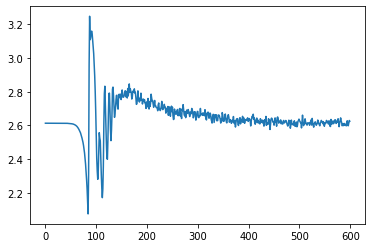

In [56]:
plt.plot(mses)

In [57]:
tf.clip_by_value(urm @ sim_matrix, 0., 5.)

<tf.Tensor: shape=(610, 9724), dtype=float32, numpy=
array([[4.1198769e+00, 4.2653818e+00, 4.1442504e+00, ..., 0.0000000e+00,
        0.0000000e+00, 5.1378205e-02],
       [5.4507166e-01, 3.6893398e-01, 2.8853881e-01, ..., 4.3933537e-02,
        5.1679142e-02, 5.2021250e-02],
       [1.2345826e-01, 1.8353513e-01, 1.7450014e-01, ..., 1.6052402e-03,
        7.5449137e-04, 2.6775086e-03],
       ...,
       [5.0000000e+00, 5.0000000e+00, 5.0000000e+00, ..., 1.5422268e-02,
        2.4211006e-02, 2.4090995e-01],
       [1.8412304e+00, 1.2207282e+00, 8.9727044e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.0612406e-02],
       [5.0000000e+00, 5.0000000e+00, 5.0000000e+00, ..., 3.1941333e-01,
        3.0100960e-01, 4.6874857e-01]], dtype=float32)>

In [58]:
masked_mse(tf.clip_by_value(urm @ sim_matrix, 0., 5.), urm, mask, sim_matrix, 0.)

<tf.Tensor: shape=(), dtype=float32, numpy=2.590948>

In [59]:
k=tf.keras

In [61]:
ratings = pd.read_csv(CUR_DIR + '/ml-latest-small/ratings.csv')

C = 3
total_mean = ratings.rating.mean()
ratings['normalized_rating'] = ratings.rating - total_mean

b_item = ratings.groupby('movieId').normalized_rating.sum() / (ratings.groupby('movieId').userId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_item, columns=['b_item']), left_on='movieId', right_index=True, how='inner')
ratings['norm_item_rating'] = ratings.normalized_rating - ratings.b_item

b_user = ratings.groupby('userId').norm_item_rating.sum() / (ratings.groupby('userId').movieId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_user, columns=['b_user']), left_on='userId', right_index=True, how='inner')

ratings['normr_user_item_rating'] = total_mean + ratings.b_item + ratings.b_user

In [62]:
b_item

movieId
1         0.413602
2        -0.067887
3        -0.228745
4        -0.801090
5        -0.405313
            ...   
193581    0.124611
193583   -0.000389
193585   -0.000389
193587   -0.000389
193609    0.124611
Length: 9724, dtype: float64

In [63]:
urm = tf.constant(ratings.pivot(index='userId', columns='movieId', values='normr_user_item_rating').fillna(0.).values, dtype=tf.float32)

In [64]:
mask = tf.not_equal(urm, tf.constant(0., dtype=tf.float32))
non_zero_rating_ixs = tf.where(mask)
non_zero_ratings = tf.gather_nd(urm, non_zero_rating_ixs)

split = 0.90
split_ix = int(split * non_zero_rating_ixs.shape[0])

non_zero_rating_ixs_shuffled = tf.random.shuffle(tf.range(non_zero_ratings.shape))

train_urm_ratings = tf.gather(non_zero_ratings, non_zero_rating_ixs_shuffled[:split_ix])
train_urm_ratings_ixs = tf.gather(non_zero_rating_ixs, non_zero_rating_ixs_shuffled[:split_ix])
test_urm_ratings = tf.gather(non_zero_ratings, non_zero_rating_ixs_shuffled[split_ix:])
test_urm_ratings_ixs = tf.gather(non_zero_rating_ixs, non_zero_rating_ixs_shuffled[split_ix:])

train_urm = tf.scatter_nd(train_urm_ratings_ixs, train_urm_ratings, urm.shape)
test_urm = tf.scatter_nd(test_urm_ratings_ixs, test_urm_ratings, urm.shape)

In [66]:
test_urm_ratings_ixs

<tf.Tensor: shape=(10084, 2), dtype=int64, numpy=
array([[ 413, 3047],
       [  73, 1257],
       [ 387,  898],
       ...,
       [ 273, 5011],
       [ 273, 1324],
       [ 317,  508]])>

In [67]:
@tf.function
def masked_mse(y_pred, y_true, mask, weights_1, lamb1, weights_2, lamb2):
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    y_true_masked = tf.boolean_mask(y_true, mask)
    return tf.losses.mean_squared_error(y_true_masked, y_pred_masked) + lamb1 * tf.norm(weights_1) + lamb2 * tf.norm(weights_2)

In [69]:
emb_dim = 30
user_emb = tf.Variable(tf.random.uniform(shape=(urm.shape[0],emb_dim)), trainable=True)
item_emb = tf.Variable(tf.random.uniform(shape=(urm.shape[1],emb_dim)), trainable=True)

mask = tf.not_equal(train_urm, tf.constant(0, dtype=tf.float32))
test_mask = tf.not_equal(test_urm, 0.)

epochs = 400
opti = tf.optimizers.Adam()
loss = masked_mse
train_mses = []
test_mses = []

for e in range(epochs):
  with tf.GradientTape(watch_accessed_variables=False) as gt1:
      
    gt1.watch(user_emb)
    with tf.GradientTape(watch_accessed_variables=False) as gt2:

      gt2.watch(item_emb)

      preds = tf.matmul(user_emb, item_emb, transpose_b=True)
      mse = loss(preds, train_urm, mask, user_emb, 0.5, item_emb, 0.4)
      
      grads = gt1.gradient(mse, user_emb)
      opti.apply_gradients(grads_and_vars=zip([grads], [user_emb])) 

      grads = gt2.gradient(mse, item_emb)
      opti.apply_gradients(grads_and_vars=zip([grads], [item_emb]))

      test_mses.append(masked_mse(tf.matmul(user_emb, item_emb, transpose_b=True), test_urm, test_mask, 0.,0.,0.,0.))
      train_mses.append(masked_mse(tf.matmul(user_emb, item_emb, transpose_b=True), train_urm, mask, 0.,0.,0.,0.))
      print(f'Epoch: {e} - Train Loss: {train_mses[-1]} - Test Loss: {test_mses[-1]}')

Epoch: 0 - Train Loss: 16.956300735473633 - Test Loss: 16.799762725830078
Epoch: 1 - Train Loss: 16.762908935546875 - Test Loss: 16.607070922851562
Epoch: 2 - Train Loss: 16.56734848022461 - Test Loss: 16.412214279174805
Epoch: 3 - Train Loss: 16.36725425720215 - Test Loss: 16.212841033935547
Epoch: 4 - Train Loss: 16.162073135375977 - Test Loss: 16.00840187072754
Epoch: 5 - Train Loss: 15.95179271697998 - Test Loss: 15.7988862991333
Epoch: 6 - Train Loss: 15.736639022827148 - Test Loss: 15.584519386291504
Epoch: 7 - Train Loss: 15.51695728302002 - Test Loss: 15.365650177001953
Epoch: 8 - Train Loss: 15.293163299560547 - Test Loss: 15.142688751220703
Epoch: 9 - Train Loss: 15.065713882446289 - Test Loss: 14.916098594665527
Epoch: 10 - Train Loss: 14.835090637207031 - Test Loss: 14.68635368347168
Epoch: 11 - Train Loss: 14.601786613464355 - Test Loss: 14.453948974609375
Epoch: 12 - Train Loss: 14.366297721862793 - Test Loss: 14.219379425048828
Epoch: 13 - Train Loss: 14.129108428955078 

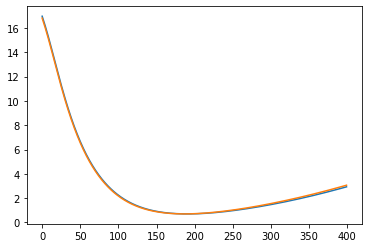

In [70]:
import matplotlib.pyplot as plt

plt.plot(train_mses)
plt.plot(test_mses)

In [71]:
masked_mse(tf.matmul(user_emb, item_emb, transpose_b=True), train_urm, mask,0.,0.,0.,0.)

<tf.Tensor: shape=(), dtype=float32, numpy=2.9325097>

In [72]:
test_mask = tf.not_equal(test_urm, 0.)
masked_mse(tf.matmul(user_emb, item_emb, transpose_b=True), test_urm, test_mask, 0.,0.,0.,0.)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0651898>

In [73]:
tf.boolean_mask(tf.matmul(user_emb, item_emb, transpose_b=True), test_mask)

<tf.Tensor: shape=(10084,), dtype=float32, numpy=
array([2.4166148, 2.732738 , 1.5094749, ..., 1.6962771, 1.8273033,
       2.786995 ], dtype=float32)>

In [74]:
tf.boolean_mask(test_urm, test_mask)

<tf.Tensor: shape=(10084,), dtype=float32, numpy=
array([4.462924 , 4.169282 , 3.7919862, ..., 4.0944376, 3.444671 ,
       4.076992 ], dtype=float32)>

In [75]:
ratings = pd.read_csv(CUR_DIR + '/ml-latest-small/ratings.csv')

C = 3
total_mean = ratings.rating.mean()
ratings['normalized_rating'] = ratings.rating - total_mean

b_item = ratings.groupby('movieId').normalized_rating.sum() / (ratings.groupby('movieId').userId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_item, columns=['b_item']), left_on='movieId', right_index=True, how='inner')
ratings['norm_item_rating'] = ratings.normalized_rating - ratings.b_item

b_user = ratings.groupby('userId').norm_item_rating.sum() / (ratings.groupby('userId').movieId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_user, columns=['b_user']), left_on='userId', right_index=True, how='inner')

ratings['normr_user_item_rating'] = total_mean + ratings.b_item + ratings.b_user

In [77]:
@tf.function
def masked_mse(y_pred, y_true, mask, weights_1, lamb1, weights_2, lamb2):
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    y_true_masked = tf.boolean_mask(y_true, mask)
    return tf.losses.mean_squared_error(y_true_masked, y_pred_masked) + lamb1 * tf.norm(weights_1) + lamb2 * tf.norm(weights_2)

In [78]:
mask = tf.not_equal(urm, tf.constant(0., dtype=tf.float32))
non_zero_rating_ixs = tf.where(mask)
non_zero_ratings = tf.gather_nd(urm, non_zero_rating_ixs)

split = 0.90
split_ix = int(split * non_zero_rating_ixs.shape[0])

non_zero_rating_ixs_shuffled = tf.random.shuffle(tf.range(non_zero_ratings.shape))

train_urm_ratings = tf.gather(non_zero_ratings, non_zero_rating_ixs_shuffled[:split_ix])
train_urm_ratings_ixs = tf.gather(non_zero_rating_ixs, non_zero_rating_ixs_shuffled[:split_ix])
test_urm_ratings = tf.gather(non_zero_ratings, non_zero_rating_ixs_shuffled[split_ix:])
test_urm_ratings_ixs = tf.gather(non_zero_rating_ixs, non_zero_rating_ixs_shuffled[split_ix:])

train_urm = tf.scatter_nd(train_urm_ratings_ixs, train_urm_ratings, urm.shape)
test_urm = tf.scatter_nd(test_urm_ratings_ixs, test_urm_ratings, urm.shape)

In [79]:
non_zero_rating_ixs

<tf.Tensor: shape=(100836, 2), dtype=int64, numpy=
array([[   0,    0],
       [   0,    2],
       [   0,    5],
       ...,
       [ 609, 9444],
       [ 609, 9445],
       [ 609, 9485]])>

In [80]:
emb_dim = 30
user_emb = tf.Variable(tf.random.uniform(shape=(urm.shape[0],emb_dim)), trainable=True)
item_emb = tf.Variable(tf.random.uniform(shape=(urm.shape[1],emb_dim)), trainable=True)
user_bias = tf.Variable(tf.random.uniform(shape=(urm.shape[0],1)), trainable=True)
item_bias = tf.Variable(tf.random.uniform(shape=(1, urm.shape[1])), trainable=True)
mean_rating = tf.Variable(tf.random.uniform(shape=(1,1)), trainable=True)

mask = tf.not_equal(train_urm, tf.constant(0, dtype=tf.float32))
test_mask = tf.not_equal(test_urm, 0.)

In [83]:
epochs = 3000
opti = tf.optimizers.Adam()
loss = masked_mse
train_mses = []
test_mses = []

for e in range(epochs):      

  with tf.GradientTape(watch_accessed_variables=False) as gt1:

    gt1.watch(item_emb)
    gt1.watch(user_emb)
    gt1.watch(item_bias)
    gt1.watch(user_bias)
    gt1.watch(mean_rating)

    global_effects = user_bias + item_bias + mean_rating
    preds = (tf.matmul(user_emb, item_emb, transpose_b=True)) + global_effects
    preds = tf.clip_by_value(preds, 0., 5.)

    mse = loss(preds, train_urm, mask, user_emb, 0.5, item_emb, 0.6)
    
    grads = gt1.gradient([mse], [user_emb, item_emb, item_bias, user_bias, mean_rating])
    opti.apply_gradients(grads_and_vars=zip(grads, [user_emb, item_emb, item_bias, user_bias, mean_rating])) 

    test_mses.append(masked_mse(tf.matmul(user_emb, item_emb, transpose_b=True) + global_effects, test_urm, test_mask, 0.,0.,0.,0.))
    train_mses.append(masked_mse(tf.matmul(user_emb, item_emb, transpose_b=True) + global_effects, train_urm, mask, 0.,0.,0.,0.))
    print(f'Epoch: {e} - Train Loss: {train_mses[-1]} - Test Loss: {test_mses[-1]}')

Epoch: 0 - Train Loss: 34.83883285522461 - Test Loss: 34.7446403503418
Epoch: 1 - Train Loss: 34.482784271240234 - Test Loss: 34.38923645019531
Epoch: 2 - Train Loss: 34.129051208496094 - Test Loss: 34.03615188598633
Epoch: 3 - Train Loss: 33.778133392333984 - Test Loss: 33.685874938964844
Epoch: 4 - Train Loss: 33.42972946166992 - Test Loss: 33.33810806274414
Epoch: 5 - Train Loss: 33.08396911621094 - Test Loss: 32.99298858642578
Epoch: 6 - Train Loss: 32.74095916748047 - Test Loss: 32.65060806274414
Epoch: 7 - Train Loss: 32.40068435668945 - Test Loss: 32.31096649169922
Epoch: 8 - Train Loss: 32.06315612792969 - Test Loss: 31.974061965942383
Epoch: 9 - Train Loss: 31.72873878479004 - Test Loss: 31.640277862548828
Epoch: 10 - Train Loss: 31.396987915039062 - Test Loss: 31.309162139892578
Epoch: 11 - Train Loss: 31.067955017089844 - Test Loss: 30.980762481689453
Epoch: 12 - Train Loss: 30.741579055786133 - Test Loss: 30.655025482177734
Epoch: 13 - Train Loss: 30.417842864990234 - Test 

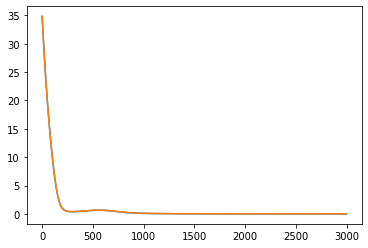

In [84]:
import matplotlib.pyplot as plt

plt.plot(train_mses)
plt.plot(test_mses)

In [85]:
print(masked_mse(tf.matmul(user_emb, item_emb, transpose_b=True) + global_effects, train_urm, mask,0.,0.,0.,0.))

tf.Tensor(4.1010848e-05, shape=(), dtype=float32)


In [86]:
test_mask = tf.not_equal(test_urm, 0.)
masked_mse(tf.matmul(user_emb, item_emb, transpose_b=True) + global_effects, test_urm, test_mask, 0.,0.,0.,0.)

<tf.Tensor: shape=(), dtype=float32, numpy=0.014719437>

In [87]:
print(tf.boolean_mask(tf.matmul(user_emb, item_emb, transpose_b=True) + global_effects, test_mask))
print(tf.boolean_mask(urm, test_mask))

tf.Tensor([5.0182815 3.7925973 5.0045686 ... 3.2204056 3.504787  4.144094 ], shape=(10084,), dtype=float32)
tf.Tensor([5.0187025 3.7919607 5.0068946 ... 3.2200649 3.501555  4.1439705], shape=(10084,), dtype=float32)


In [88]:
# Hybrid Linear Combination

def get_hybrid_rating_given_user(u_ix, item_ix, k, alpha, beta):
  return alpha * cbf_get_rating_given_user(u_ix, item_ix, k)[0] + \
        beta * ucf_get_rating_given_user(u_ix, item_ix, k)[0]

In [89]:
ratings = pd.read_csv(CUR_DIR + '/ml-latest-small/ratings.csv')

C = 3
total_mean = ratings.rating.mean()
ratings['normalized_rating'] = ratings.rating - total_mean

b_item = ratings.groupby('movieId').normalized_rating.sum() / (ratings.groupby('movieId').userId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_item, columns=['b_item']), left_on='movieId', right_index=True, how='inner')
ratings['norm_item_rating'] = ratings.normalized_rating - ratings.b_item

b_user = ratings.groupby('userId').norm_item_rating.sum() / (ratings.groupby('userId').movieId.count() + C)
ratings = ratings.merge(pd.DataFrame(b_user, columns=['b_user']), left_on='userId', right_index=True, how='inner')

ratings['normr_user_item_rating'] = total_mean + ratings.b_item + ratings.b_user
urm = ratings.pivot(index='userId', columns='movieId', values='normr_user_item_rating').fillna(0.).values

get_hybrid_rating_given_user(25,15,100, 0.9, 1.9)

array([1.5497309], dtype=float32)